## Importamos librerías



In [1]:
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import roc_curve, roc_auc_score, auc
from statistics import mode
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [2]:
!pip install --upgrade scikit-learn

In [2]:
!pip install -U pycaret

## Lectura y manipulación del dataset

### Lectura y selección de 10 ciudades al azar

In [3]:
data = pd.read_csv("weatherAUS.csv")
data


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
# Guardamos en una lista, las ciudades del dataset
lista_ciudades = data['Location'].unique()
# Tomamos 10 ciudades de forma aleatoria
np.random.seed(42) # Establece una semilla fija
seleccion_ciudades = np.random.choice(lista_ciudades, 10, replace=False)
seleccion_ciudades

array(['Williamtown', 'AliceSprings', 'Katherine', 'Launceston',
       'MountGinini', 'Dartmoor', 'Watsonia', 'Portland', 'Townsville',
       'Bendigo'], dtype=object)

In [5]:
#Filtramos el dataset y nos quedamos sólo con las filas correspondientes a las ciudades seleccionadas
df_clima = data[data['Location'].isin(seleccion_ciudades)]
df_clima

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
39538,2009-01-01,Williamtown,15.2,34.0,0.0,11.6,9.2,NW,41.0,WNW,...,62.0,36.0,1005.2,1001.5,3.0,6.0,23.7,28.7,No,No
39539,2009-01-02,Williamtown,18.3,24.5,0.0,8.8,9.4,S,54.0,S,...,61.0,57.0,1012.1,1011.7,3.0,2.0,21.6,23.4,No,No
39540,2009-01-03,Williamtown,16.8,23.5,0.4,8.4,0.4,NE,37.0,ESE,...,60.0,58.0,1020.4,1018.4,7.0,7.0,20.1,21.7,No,No
39541,2009-01-04,Williamtown,17.5,27.8,0.0,5.0,12.0,E,50.0,NE,...,60.0,51.0,1018.4,1014.6,1.0,1.0,22.7,26.4,No,No
39542,2009-01-05,Williamtown,14.8,36.0,0.0,8.6,11.9,ENE,37.0,NNW,...,67.0,39.0,1013.6,1008.7,2.0,3.0,22.5,33.8,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143877,2017-06-21,Katherine,15.4,31.5,0.0,3.6,NaN,ESE,43.0,ESE,...,70.0,NaN,1016.6,1012.7,0.0,NaN,21.6,NaN,No,No
143878,2017-06-22,Katherine,12.2,31.5,0.0,4.0,NaN,ESE,37.0,SE,...,45.0,NaN,1017.1,1012.8,0.0,NaN,19.9,NaN,No,No
143879,2017-06-23,Katherine,14.9,31.5,0.0,6.4,NaN,ESE,41.0,SE,...,74.0,NaN,1016.1,1011.8,0.0,NaN,22.8,NaN,No,No
143880,2017-06-24,Katherine,14.0,NaN,0.0,10.0,NaN,E,35.0,E,...,74.0,NaN,1014.6,1011.1,2.0,NaN,22.2,NaN,No,NaN


### Análisis descriptivo y correcciones sobre algunas variables categóricas

In [6]:
#Vemos cuáles son las variables, obteniendo las columnas del dataset:
df_clima.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
#Vemos tipos de datos:
df_clima.dtypes

,0
Date,object
Location,object
MinTemp,float64
MaxTemp,float64
Rainfall,float64
Evaporation,float64
Sunshine,float64
WindGustDir,object
WindGustSpeed,float64
WindDir9am,object


La primera variable, 'date', es la fecha en la que se tomaron los datos (en formato AAAA-MM-DD). La segunda, 'Location', es la ciudad.

Luego, 'MinTemp' y 'MaxTemp', que representan las temperaturas mínimas y máximas, respectivamente, que registraron en esa fecha y ciudad.

'Rainfall' representa la cantidad de lluvia registrada, mientras que 'Evaporation', la cantidad de agua evaporada.

'Sunshine', la cantidad de tiempo de luz solar.

'WindGustDir' y 'WindGustSpeed' representan la dirección y velocidad máxima de las ráfagas de viento.

Las variables 'WindDir9am', 'WindDir3pm', 'WindSpeed9am' y 'WindSpeed3pm' representan las direcciones y velocidades del viento a las 9am y a las 3pm.

De manera similar, 'Humidity9am',	'Humidity3pm', 'Pressure9am',
Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am' y 'Temp3pm' dan humedad, presión, nubosidad y temperatura en dichos horarios.

En general, no tenemos información sobre las unidades tomadas para estas mediciones.

Por último, 'RainToday' y 'RainTomorrow' son variables categóricas, que indican si llovió o no ese mismo día y el siguiente, respectivamente.

In [8]:
# Vemos características de las variables numéricas. El rango de variación de las mismas se observa a partir de los valores min y max
df_clima.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,28576.000000,28640.000000,28084.000000,18737.000000,14632.000000,28043.000000,28494.000000,28498.000000,27982.000000,27405.000000,24514.000000,24517.000000,17919.000000,17164.000000,28212.000000,27703.000000
mean,11.085414,22.247437,2.402197,5.766686,7.417749,39.948971,13.343300,18.369429,70.997105,54.104944,1016.993681,1014.572403,4.533624,4.619786,16.014380,20.587189
std,7.100826,8.464012,8.383588,4.444280,3.894355,13.134511,8.207158,8.140635,21.508288,22.295235,7.266884,7.340365,2.939539,2.759977,7.693444,8.156476
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,1.000000,985.000000,980.200000,0.000000,0.000000,-7.200000,-5.400000
25%,6.100000,15.800000,0.000000,2.600000,4.300000,31.000000,7.000000,13.000000,59.000000,39.000000,1012.200000,1009.500000,1.000000,2.000000,10.600000,14.500000
50%,10.400000,21.400000,0.000000,5.200000,8.200000,39.000000,13.000000,19.000000,73.000000,55.000000,1017.000000,1014.500000,5.000000,5.000000,15.000000,19.800000
75%,15.700000,28.800000,0.800000,7.800000,10.700000,46.000000,19.000000,24.000000,89.000000,69.000000,1021.800000,1019.500000,7.000000,7.000000,21.600000,26.600000
max,30.300000,46.700000,236.800000,145.000000,14.300000,135.000000,65.000000,72.000000,100.000000,100.000000,1040.500000,1039.600000,8.000000,8.000000,39.100000,45.200000


In [9]:
#Vemos qué valores toman las variables categóricas:
df_clima['WindGustDir'].unique()  #Vemos que hay valores con errores y los corregimos a continuación

array(['NW', 'S', 'NE', 'E', 'ENE', 'SSW', 'ESE', nan, 'SE', 'SSE', 'N',
       'SW', 'WNW', 'W', 'WSW', 'NNW', 'NNE'], dtype=object)

In [10]:
df_clima['WindGustDir'] = df_clima['WindGustDir'].replace({'ENE': 'NE', 'SSW': 'SW', 'ESE': 'SE', 'SSE': 'SE', 'WNW': 'NW', 'WSW': 'SW', 'NNW': 'NW', 'NNE': 'NE'})

<ipython-input-10-ac07074ea0c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clima['WindGustDir'] = df_clima['WindGustDir'].replace({'ENE': 'NE', 'SSW': 'SW', 'ESE': 'SE', 'SSE': 'SE', 'WNW': 'NW', 'WSW': 'SW', 'NNW': 'NW', 'NNE': 'NE'})


In [11]:
df_clima['WindDir9am'].unique()

array(['WNW', 'S', 'ESE', 'NE', 'NNW', 'SSE', 'SSW', 'SE', 'ENE', 'N',
       'W', 'NW', 'NNE', 'SW', 'E', 'WSW', nan], dtype=object)

In [12]:
df_clima['WindDir9am'] = df_clima['WindDir9am'].replace({'ENE': 'NE', 'SSW': 'SW', 'ESE': 'SE', 'SSE': 'SE', 'WNW': 'NW', 'WSW': 'SW', 'NNW': 'NW', 'NNE': 'NE'})

<ipython-input-12-0034dd453e19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clima['WindDir9am'] = df_clima['WindDir9am'].replace({'ENE': 'NE', 'SSW': 'SW', 'ESE': 'SE', 'SSE': 'SE', 'WNW': 'NW', 'WSW': 'SW', 'NNW': 'NW', 'NNE': 'NE'})


In [13]:
df_clima['WindDir3pm'].unique()

array(['SE', 'E', 'ENE', 'ESE', 'S', 'SSE', 'WNW', 'NE', 'NNW', 'SSW',
       'NW', 'N', 'NNE', 'SW', 'W', nan, 'WSW'], dtype=object)

In [14]:
df_clima['WindDir3pm'] = df_clima['WindDir3pm'].replace({'ENE': 'NE', 'SSW': 'SW', 'ESE': 'SE', 'SSE': 'SE', 'WNW': 'NW', 'WSW': 'SW', 'NNW': 'NW', 'NNE': 'NE'})

<ipython-input-14-fbc33826ae96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clima['WindDir3pm'] = df_clima['WindDir3pm'].replace({'ENE': 'NE', 'SSW': 'SW', 'ESE': 'SE', 'SSE': 'SE', 'WNW': 'NW', 'WSW': 'SW', 'NNW': 'NW', 'NNE': 'NE'})


In [15]:
df_clima['RainToday'].unique()

array(['No', 'Yes', nan], dtype=object)

In [16]:
df_clima['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

### Codificación de variables categóricas


In [17]:
#Codificamos variables categóricas RainToday y RainTomorrow

df_clima['RainToday'] = np.where(df_clima['RainToday'] == 'Yes', 1, 0)
df_clima['RainTomorrow'] = np.where(df_clima['RainTomorrow'] == 'Yes', 1, 0)

<ipython-input-17-a3c8b5a076be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clima['RainToday'] = np.where(df_clima['RainToday'] == 'Yes', 1, 0)
<ipython-input-17-a3c8b5a076be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clima['RainTomorrow'] = np.where(df_clima['RainTomorrow'] == 'Yes', 1, 0)


### Tratamiento de valores nulos:

In [18]:
#Eliminamos filas donde la variable respuesta tiene valores nulos:
df_clima1 = df_clima.dropna(subset=['RainTomorrow'])
df_clima1.shape #Chequeamos tamaño

(28814, 23)

In [19]:
#Vemos cantidad de valores nulos en el data set:
df_clima1.isna().sum()

,0
Date,0
Location,0
MinTemp,238
MaxTemp,174
Rainfall,730
Evaporation,10077
Sunshine,14182
WindGustDir,774
WindGustSpeed,771
WindDir9am,2263


Observamos que hay variables con gran cantidad de valores nulos, como por ejemplo la variable Sunshine, con un 48% de datos faltantes sobre el total de datos, o Cloud3pm con un 40% aprox de valores nulos. Por esto decidimos imputar las valores faltantes de las variables numéricas utilizando el método de los K-Vecinos más cercanos.

In [20]:
# Filtramos solo columnas numéricas
df_numerico = df_clima1.select_dtypes(include=[np.number])

# Aplicamos KNNImputer solo a las columnas numéricas
knn_imputer = KNNImputer()
df_numerico_imputado = pd.DataFrame(knn_imputer.fit_transform(df_numerico), columns=df_numerico.columns)

# Se reinicia el índice de ambos DataFrames antes de concatenar
df_numerico_imputado.reset_index(drop=True, inplace=True)
df_no_numerico = df_clima1.select_dtypes(exclude=[np.number]).reset_index(drop=True)

# Unimos nuevamente con las columnas no numéricas
df_clima2 = pd.concat([df_no_numerico, df_numerico_imputado], axis=1)

print("\nDataFrame después de la imputación basada en K-Vecinos más cercanos:")
print(df_clima2.head())


DataFrame después de la imputación basada en K-Vecinos más cercanos:
         Date     Location WindGustDir WindDir9am WindDir3pm  MinTemp  \
0  2009-01-01  Williamtown          NW         NW         SE     15.2   
1  2009-01-02  Williamtown           S          S          E     18.3   
2  2009-01-03  Williamtown          NE         SE         NE     16.8   
3  2009-01-04  Williamtown           E         NE         NE     17.5   
4  2009-01-05  Williamtown          NE         NW         NE     14.8   

   MaxTemp  Rainfall  Evaporation  Sunshine  ...  Humidity9am  Humidity3pm  \
0     34.0       0.0         11.6       9.2  ...         62.0         36.0   
1     24.5       0.0          8.8       9.4  ...         61.0         57.0   
2     23.5       0.4          8.4       0.4  ...         60.0         58.0   
3     27.8       0.0          5.0      12.0  ...         60.0         51.0   
4     36.0       0.0          8.6      11.9  ...         67.0         39.0   

   Pressure9am  Pressu

In [21]:
#Separamos de la variable fecha el mes y lo añadimos en una columna aparte
df_clima2['Date'] = pd.to_datetime(df_clima2['Date'])
df_clima2['Mes'] = df_clima2['Date'].dt.month

In [22]:
df_clima2.head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Mes
0,2009-01-01,Williamtown,NW,NW,SE,15.2,34.0,0.0,11.6,9.2,...,36.0,1005.2,1001.5,3.0,6.0,23.7,28.7,0.0,0.0,1
1,2009-01-02,Williamtown,S,S,E,18.3,24.5,0.0,8.8,9.4,...,57.0,1012.1,1011.7,3.0,2.0,21.6,23.4,0.0,0.0,1
2,2009-01-03,Williamtown,NE,SE,NE,16.8,23.5,0.4,8.4,0.4,...,58.0,1020.4,1018.4,7.0,7.0,20.1,21.7,0.0,0.0,1
3,2009-01-04,Williamtown,E,NE,NE,17.5,27.8,0.0,5.0,12.0,...,51.0,1018.4,1014.6,1.0,1.0,22.7,26.4,0.0,0.0,1
4,2009-01-05,Williamtown,NE,NW,NE,14.8,36.0,0.0,8.6,11.9,...,39.0,1013.6,1008.7,2.0,3.0,22.5,33.8,0.0,0.0,1


Para las variables categóricas pensamos en imputar los valores faltantes con la moda correspondiente a cada mes.

In [23]:
moda_por_mes_windgustdir = {}
moda_por_mes_winddir9am = {}
moda_por_mes_winddir3pm = {}
moda_por_mes_raintoday = {}

for mes, grupo in df_clima2.groupby('Mes'):
    moda_por_mes_windgustdir[mes] = grupo['WindGustDir'].mode().iloc[0]
    moda_por_mes_winddir9am[mes] = grupo['WindDir9am'].mode().iloc[0]
    moda_por_mes_winddir3pm[mes] = grupo['WindDir3pm'].mode().iloc[0]
    moda_por_mes_raintoday[mes] = grupo['RainToday'].mode().iloc[0]

for i in range(1,13):
  imputer1 = SimpleImputer(strategy='constant', fill_value = moda_por_mes_windgustdir[i])
  imputer2 = SimpleImputer(strategy='constant', fill_value = moda_por_mes_winddir9am[i])
  imputer3 = SimpleImputer(strategy='constant', fill_value = moda_por_mes_winddir3pm[i])
  imputer4 = SimpleImputer(strategy='constant', fill_value = moda_por_mes_raintoday[i])
  # Imputar solo las filas correspondientes al mes actual para WindGustDir
  df_clima2.loc[df_clima2['Mes'] == i, 'WindGustDir'] = imputer1.fit_transform(
        df_clima2.loc[df_clima2['Mes'] == i, 'WindGustDir'].values.reshape(-1, 1))
  # Imputar solo las filas correspondientes al mes actual para WindDir9am
  df_clima2.loc[df_clima2['Mes'] == i, 'WindDir9am'] = imputer2.fit_transform(
        df_clima2.loc[df_clima2['Mes'] == i, 'WindDir9am'].values.reshape(-1, 1))
  # Imputar solo las filas correspondientes al mes actual para WindDir3pm
  df_clima2.loc[df_clima2['Mes'] == i, 'WindDir3pm'] = imputer3.fit_transform(
        df_clima2.loc[df_clima2['Mes'] == i, 'WindDir3pm'].values.reshape(-1, 1))
  # Imputar solo las filas correspondientes al mes actual para RainToday
  df_clima2.loc[df_clima2['Mes'] == i, 'RainToday'] = imputer4.fit_transform(
        df_clima2.loc[df_clima2['Mes'] == i, 'RainToday'].values.reshape(-1, 1))

### Codificación de otras variables categóricas

In [24]:
# Codificación de variable Mes
lista_mes=[]

i = 0 # Inicializamos variables
paso = math.pi / 6

# Bucle mientras el valor de i sea menor o igual a 2*pi
while i <= 2 * math.pi:
    lista_mes.append((round(math.cos(i), 2), round(math.sin(i), 2)))
    i += paso


# Definimos una función que asigna los valores de x_mes e y_mes según el mes
def asignar_coordenadas(mes):
    x_mes = lista_mes[mes-1][0]  # (Los índices en lista_mes van de 0 a 11)
    y_mes = lista_mes[mes-1][1]
    return pd.Series([x_mes, y_mes], index=['x_mes', 'y_mes'])

# Aplicamos la función para cada fila de df_clima2
df_clima2[['x_mes', 'y_mes']] = df_clima2['Mes'].apply(asignar_coordenadas)

# Vemos las primeras filas
df_clima2.head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Mes,x_mes,y_mes
0,2009-01-01,Williamtown,NW,NW,SE,15.2,34.0,0.0,11.6,9.2,...,1001.5,3.0,6.0,23.7,28.7,0.0,0.0,1,1.0,0.0
1,2009-01-02,Williamtown,S,S,E,18.3,24.5,0.0,8.8,9.4,...,1011.7,3.0,2.0,21.6,23.4,0.0,0.0,1,1.0,0.0
2,2009-01-03,Williamtown,NE,SE,NE,16.8,23.5,0.4,8.4,0.4,...,1018.4,7.0,7.0,20.1,21.7,0.0,0.0,1,1.0,0.0
3,2009-01-04,Williamtown,E,NE,NE,17.5,27.8,0.0,5.0,12.0,...,1014.6,1.0,1.0,22.7,26.4,0.0,0.0,1,1.0,0.0
4,2009-01-05,Williamtown,NE,NW,NE,14.8,36.0,0.0,8.6,11.9,...,1008.7,2.0,3.0,22.5,33.8,0.0,0.0,1,1.0,0.0


In [25]:
# Codificación de variables relacionadas con direcciones de viento
# Diccionario para puntos cardinales: las claves son las direcciones del viento y el valor es el ángulo asignado
# para que cada punto cardinal represente luego un punto en la circunferencia trigonométrica
direcciones = {
    'E': 0,
    'NE': math.pi / 4,
    'N': math.pi/2,
    'NW': 3*math.pi / 4,
    'W': math.pi ,
    'SW': 5*math.pi / 4,
    'S': 3*math.pi /2 ,
    'SE': 7*math.pi / 4,
}

# Función para asignar coordenadas de dirección para WindGustDir
def asignar_coordenadas_gustdir(direccion):
    angulo = direcciones[direccion]
    x_gust = round(math.cos(angulo), 2)
    y_gust = round(math.sin(angulo), 2)
    return pd.Series([x_gust, y_gust], index=['x_gust', 'y_gust'])
# Aplicamos la función a la columna Windgustdir
df_clima2[['x_gust', 'y_gust']] = df_clima2['WindGustDir'].apply(asignar_coordenadas_gustdir)

# Función para asignar coordenadas de dirección para WindDir9am:
def asignar_coordenadas_dir9am(direccion):
    angulo = direcciones[direccion]
    x_dir9am = round(math.cos(angulo), 2)
    y_dir9am = round(math.sin(angulo), 2)
    return pd.Series([x_dir9am, y_dir9am], index=['x_dir9am', 'y_dir9am'])
# Aplicar la función a la columna WindDir9am
df_clima2[['x_dir9am', 'y_dir9am']] = df_clima2['WindDir9am'].apply(asignar_coordenadas_dir9am)

# Función para asignar coordenadas de dirección para WindDir3pm:
def asignar_coordenadas_dir3pm(direccion):
    angulo = direcciones[direccion]
    x_dir3pm = round(math.cos(angulo), 2)
    y_dir3pm = round(math.sin(angulo), 2)
    return pd.Series([x_dir3pm, y_dir3pm], index=['x_dir3pm', 'y_dir3pm'])
# Aplicar la función a la columna WindDir3pm:
df_clima2[['x_dir3pm', 'y_dir3pm']] = df_clima2['WindDir3pm'].apply(asignar_coordenadas_dir3pm)

# Mostrar las primeras filas
df_clima2.head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,...,RainTomorrow,Mes,x_mes,y_mes,x_gust,y_gust,x_dir9am,y_dir9am,x_dir3pm,y_dir3pm
0,2009-01-01,Williamtown,NW,NW,SE,15.2,34.0,0.0,11.6,9.2,...,0.0,1,1.0,0.0,-0.71,0.71,-0.71,0.71,0.71,-0.71
1,2009-01-02,Williamtown,S,S,E,18.3,24.5,0.0,8.8,9.4,...,0.0,1,1.0,0.0,-0.00,-1.00,-0.00,-1.00,1.00,0.00
2,2009-01-03,Williamtown,NE,SE,NE,16.8,23.5,0.4,8.4,0.4,...,0.0,1,1.0,0.0,0.71,0.71,0.71,-0.71,0.71,0.71
3,2009-01-04,Williamtown,E,NE,NE,17.5,27.8,0.0,5.0,12.0,...,0.0,1,1.0,0.0,1.00,0.00,0.71,0.71,0.71,0.71
4,2009-01-05,Williamtown,NE,NW,NE,14.8,36.0,0.0,8.6,11.9,...,0.0,1,1.0,0.0,0.71,0.71,-0.71,0.71,0.71,0.71


In [26]:
#Codificación de la variable categórica 'Location'

encoder = OneHotEncoder(sparse_output=False)
ciudades_one_hot = encoder.fit_transform(df_clima2[['Location']])

# Creamos un nuevo dataframe con la codificación One-Hot
ciudades_df = pd.DataFrame(ciudades_one_hot, columns=encoder.get_feature_names_out(['Location']))

# Combinamos el dataframe original con el nuevo de ciudades codificadas
df_clima2 = pd.concat([df_clima2, ciudades_df], axis=1)

print(df_clima2.head())

        Date     Location WindGustDir WindDir9am WindDir3pm  MinTemp  MaxTemp  \
0 2009-01-01  Williamtown          NW         NW         SE     15.2     34.0   
1 2009-01-02  Williamtown           S          S          E     18.3     24.5   
2 2009-01-03  Williamtown          NE         SE         NE     16.8     23.5   
3 2009-01-04  Williamtown           E         NE         NE     17.5     27.8   
4 2009-01-05  Williamtown          NE         NW         NE     14.8     36.0   

   Rainfall  Evaporation  Sunshine  ...  Location_AliceSprings  \
0       0.0         11.6       9.2  ...                    0.0   
1       0.0          8.8       9.4  ...                    0.0   
2       0.4          8.4       0.4  ...                    0.0   
3       0.0          5.0      12.0  ...                    0.0   
4       0.0          8.6      11.9  ...                    0.0   

   Location_Bendigo  Location_Dartmoor  Location_Katherine  \
0               0.0                0.0                

In [27]:
df_clima2.columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Mes', 'x_mes',
       'y_mes', 'x_gust', 'y_gust', 'x_dir9am', 'y_dir9am', 'x_dir3pm',
       'y_dir3pm', 'Location_AliceSprings', 'Location_Bendigo',
       'Location_Dartmoor', 'Location_Katherine', 'Location_Launceston',
       'Location_MountGinini', 'Location_Portland', 'Location_Townsville',
       'Location_Watsonia', 'Location_Williamtown'],
      dtype='object')

## Validación cruzada - división del conjunto de datos


In [28]:
#Separación de datos
X = df_clima2.drop('RainTomorrow', axis=1)
y = df_clima2['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [29]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((20169, 41), (5763, 41), (2882, 41), (20169,), (5763,), (2882,))

## Visualización de datos

In [30]:
y_train.value_counts()

,count
RainTomorrow,
0.0,15591
1.0,4578


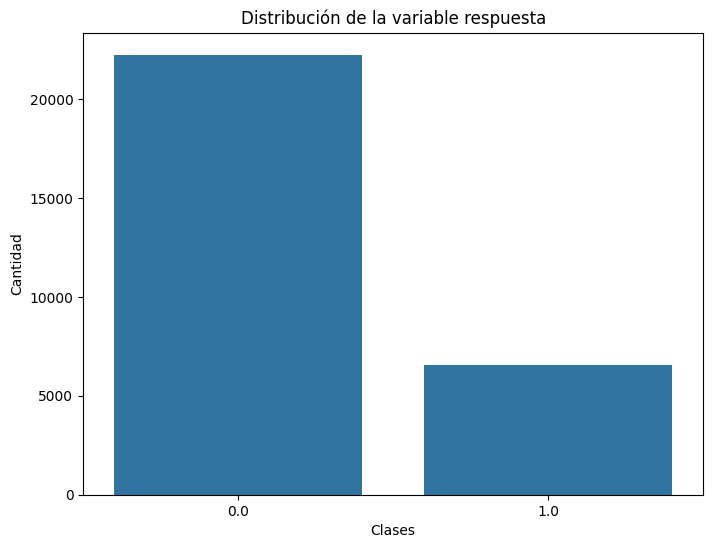

In [31]:
# Visualización del balanceo de la variable respuesta
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=df_clima2)
plt.title('Distribución de la variable respuesta')
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.show()

Observamos que hay un desbalanceo en el dataset, ya que de la variable objetivo, casi un 70% se corresponde a la respuesta "No" (codificada con 0) y un 30% aprox, a la respuesta "Yes" (codificada con 1).

In [32]:
columnas_numéricas = np.array(["MinTemp", 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday'])

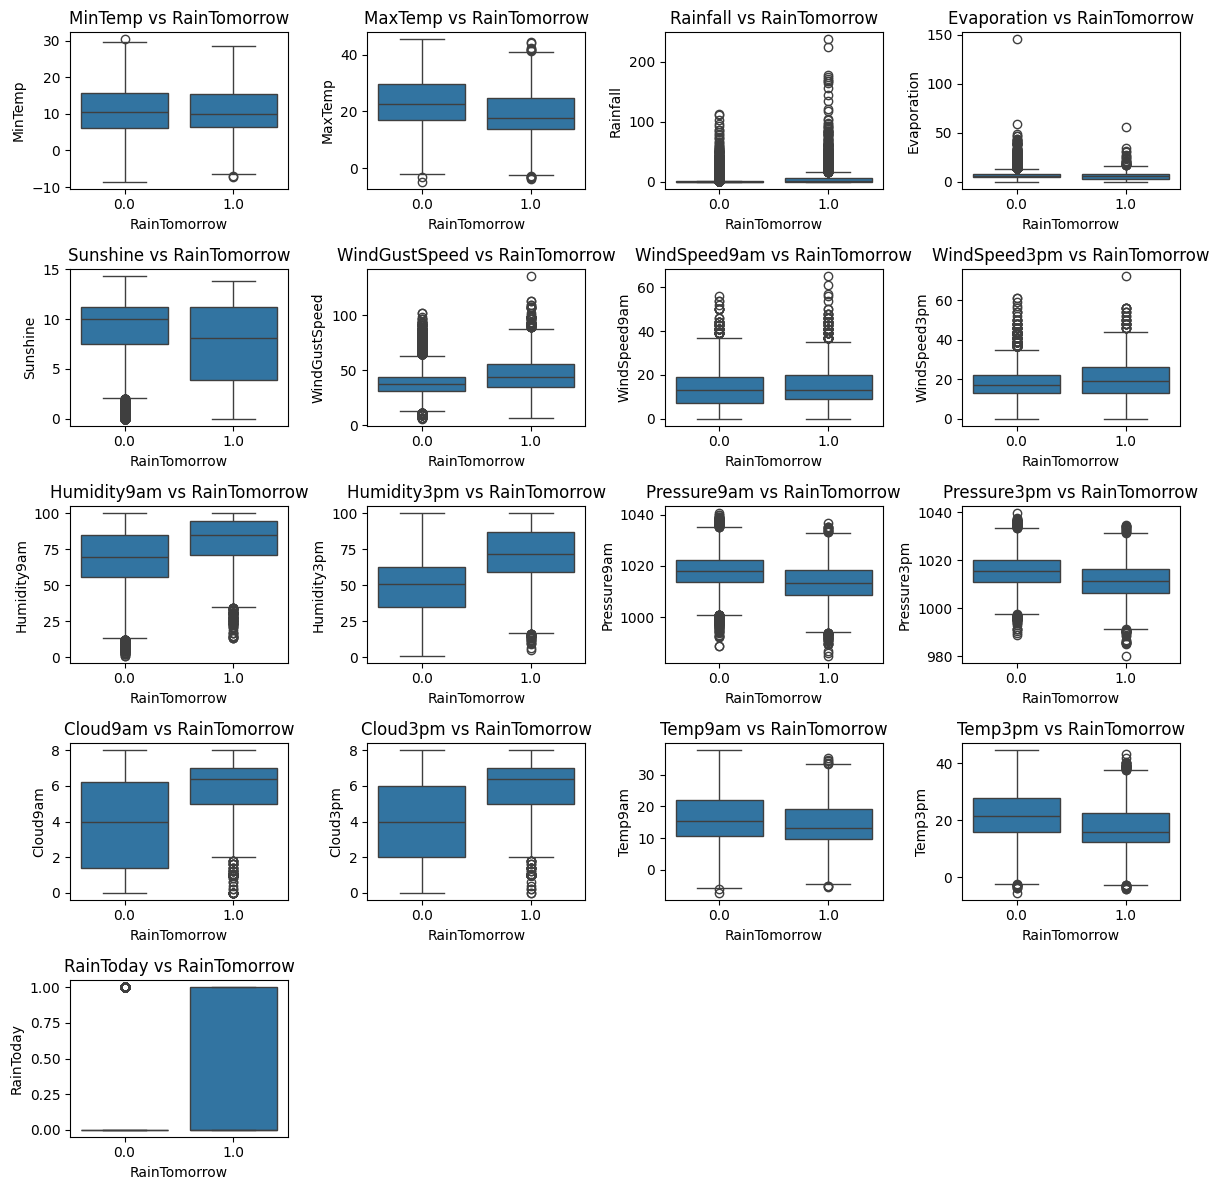

In [33]:
#Realizamos un boxplot para cada variable numérica de X_train en función de la variable respuesta

df_train_num = pd.DataFrame(X_train, columns=columnas_numéricas)
df_train_num['RainTomorrow'] = y_train  # Añade la columna de etiquetas (variable respuesta)

plt.figure(figsize=(12, 12))

# Itera sobre cada columna de X_train y genera un boxplot con respecto a la variable de respuesta
for i, column in enumerate(df_train_num.columns[:-1]):  # Excluye la columna 'target'
    plt.subplot(5, 4, i+1)
    sns.boxplot(x='RainTomorrow', y=column, data=df_train_num)
    plt.title(f'{column} vs RainTomorrow')

plt.tight_layout()
plt.show()

A partir de los boxplots que relacionan a las variables numéricas de nuestro conjunto de entrenamiento con la variable respuesta, podemos observar lo siguiente:


*   Las variables RainFall y Evaporation presentan gran cantidad de valores atípicos, tanto para el valor 0 y 1 de la variable respuesta, que se evidencian en dicho gráfico y lo podemos relacionar con lo que muestran las estadísticas descriptivas obtenidas anteriormente para las variables sin hacer esta distinción de clase. En éstas últimas se observa, por ejemplo, que la variable RainFall tiene una media de aproximadamente 2.4, una mediana de 0, pero alcanza el valor máximo de 236.8, lo que explica la presencia de estos outliers. Algo similar ocurre con la variable Evaporation.

*   Se observan diferencias en la variable Sunshine en relación a cada clase de la variable respuesta. La mediana para la clase 0 es mayor que para la clase 1, así como el primer cuartil. Los valores de la variable Sunshine tienen un rango intercuartil mayor cuando RainTomorrow es igual a 1.

- Para Humidity9am se observa que cuando la variable respuesta es igual a 1, tanto la mediana, como los cuartiles primero y tercero, son mayores.
Se puede decir que cuando sí llueve mañana, los porcentajes de humedad son generalmente más altos.  Para Humidity3pm el comportamiente es similar siendo aún más notoria la diferencia mencionada.

- Para Cloud9am y Cloud3pm, se da una distribución muy parecida entre ellas, donde vemos que cuando no llueve mañana los registros de nubosidad toman valores en su mayoría menores que cuando sí llueve. En ambos casos, la mediana para la clase 0 es 4, y para la clase 1 es mayor a 6.

- Para la relación de las demás variables con RainTomorrow, no se observan grandes diferencias para las distintas clases.


In [34]:
columnas_categoricas = np.array(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
        'RainToday', 'Mes'])

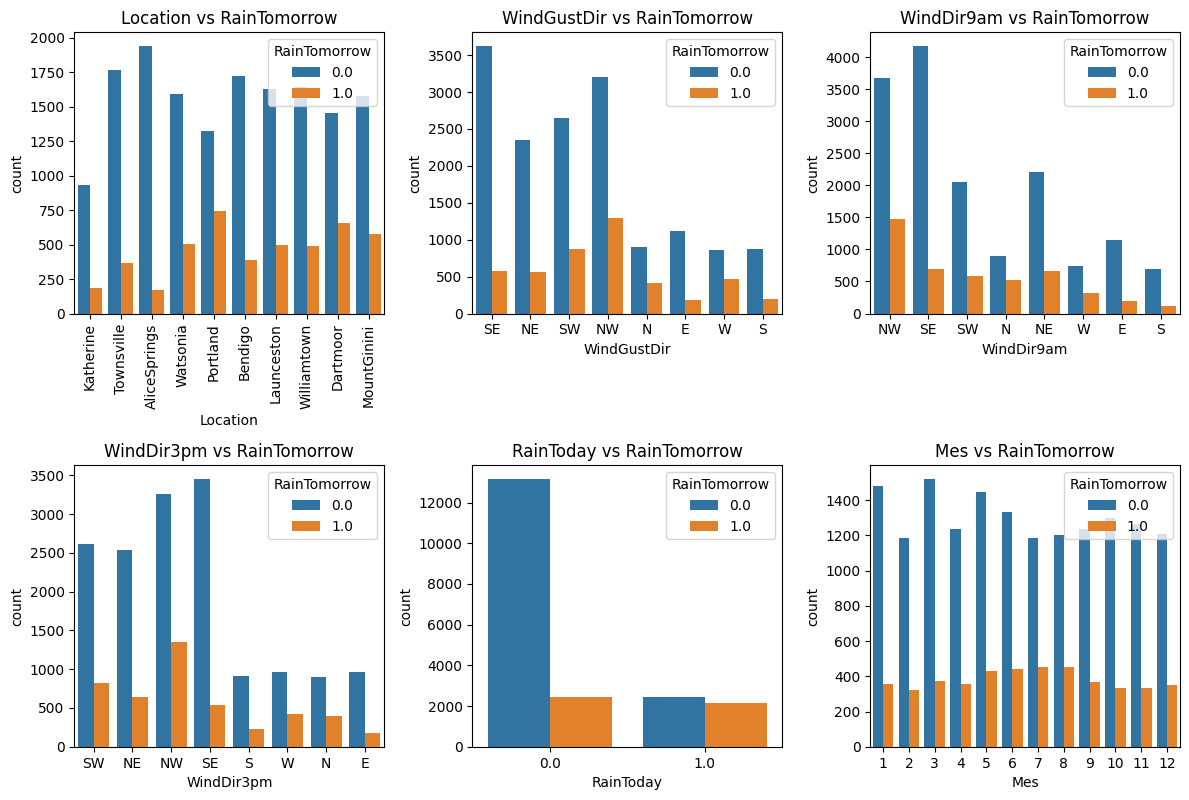

In [35]:
df_train_c = pd.DataFrame(X_train, columns=columnas_categoricas)
df_train_c['RainTomorrow'] = y_train  # Añade la columna de etiquetas (variable respuesta)

plt.figure(figsize=(12, 12))

# Itera sobre cada columna de X_train y genera un boxplot con respecto a la variable de respuesta
for i, column in enumerate(df_train_c.columns[:-1]):  # Excluye la columna 'target'
    plt.subplot(3, 3, i+1)
    sns.countplot(x=column, hue='RainTomorrow', data=df_train_c)
    plt.title(f'{column} vs RainTomorrow')
    if column=="Location":
      plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Se observa en estos gráficos que la frecuencia para cada categoría de las variables es mucho mayor para el caso de la clase 0 que para la clase 1 (tengamos en cuenta el desbalanceo del dataset).
Se puede decir que la ciudad AliceSprings es la que presenta mayor frecuencia para la clase 0 (es decir, no llueve mañana) y la que menor registros de lluvia tiene para la clase 1.
Podemos observar también que cuando la dirección del viento a las 9am y a las 3pm es SE, la frecuencia de la clase 0 es la mayor en relación a las demás direcciones. Se observan pocos registros en general para la dirección SUR del viento en estos horarios.
En la comparación con la variable RainToday vemos que los registros de que sí llueve en el día presente tienen la misma frecuencia para las clases 0 y 1 de 'RainTomorrow'. En cambio, si "hoy no llueve", es mucho más frecuente que al siguiente día tampoco llueva.


In [36]:
nombres_columnas = ["MinTemp", 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', "RainToday", "Mes", "x_mes",	"y_mes",	"x_gust",	"y_gust",	"x_dir9am",	"y_dir9am", "x_dir3pm", "y_dir3pm",
        'Location_AliceSprings', 'Location_Bendigo', 'Location_Dartmoor', 'Location_Katherine', 'Location_Launceston', 'Location_MountGinini',
        'Location_Portland', 'Location_Townsville', 'Location_Watsonia', 'Location_Williamtown']

df_train_num1 = pd.DataFrame(X_train, columns=nombres_columnas)
df_train_num1['RainTomorrow'] = y_train  # Añade la columna de etiquetas (variable respuesta)

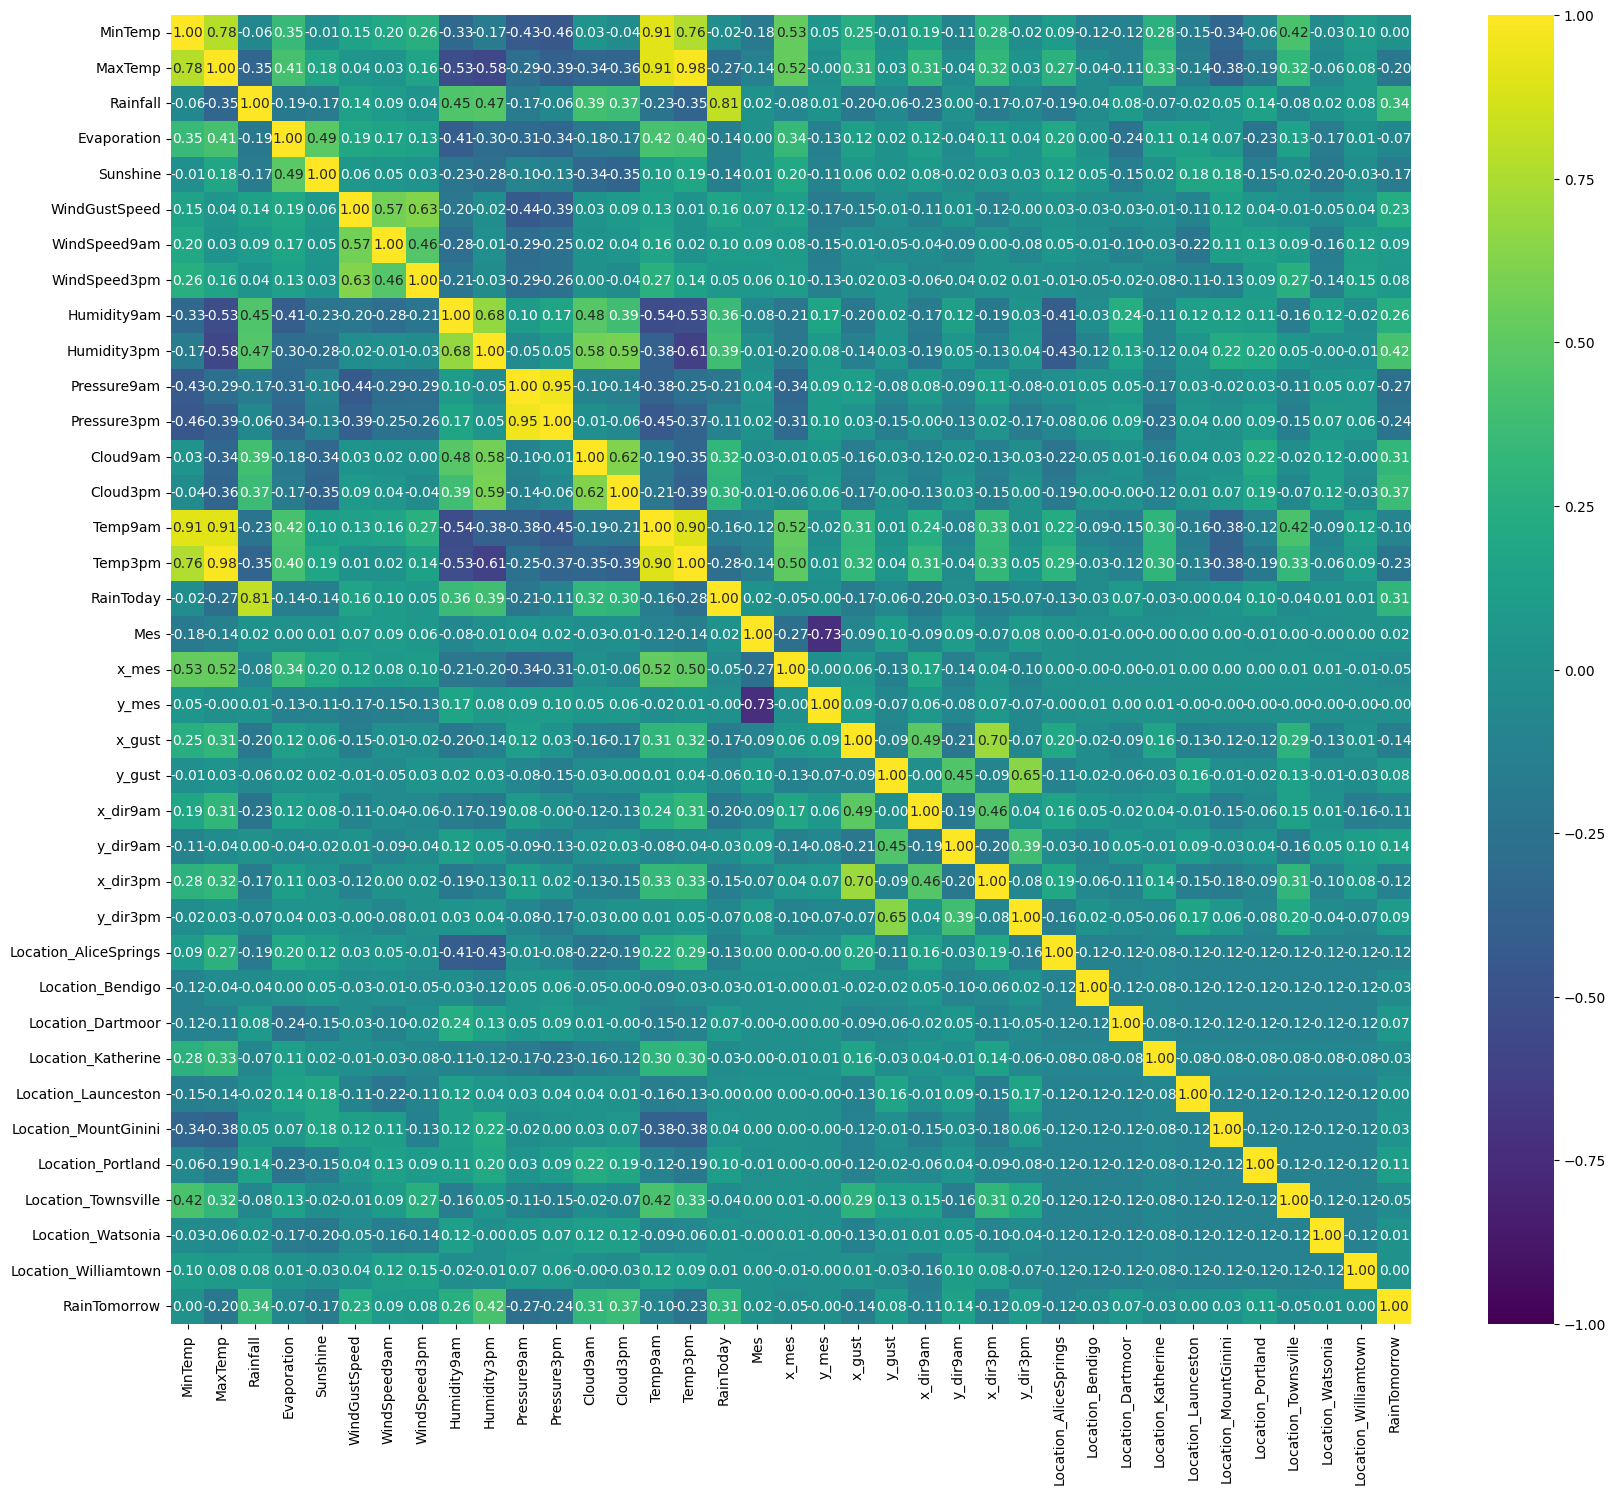

In [37]:
# Matriz de correlación de variables
plt.figure(figsize=(20, 17))
sns.heatmap (df_train_num1.corr(method = 'spearman'), annot = True, cmap='viridis', fmt=".2f", vmin=-1, vmax=1)
plt.show()

No se observan fuertes correlaciones con la variable objetivo: RainTomorrow.
Sí podemos decir que existe fuerte relación lineal entre las variables RainToday-Rainfall, Temp3pm-MaxTemp, Temp9am-MinTemp, Temp9am-MaxTemp, MaxTemp-MinTemp.

##Escalado de datos


A continuación utilizamos el escalado robusto dado que es menos sensible a los valores atípicos y pudimos observar previamente la presencia de outliers en algunas de nuestras variables. El método utiliza la mediana y el rango intercuartil para escalar los datos, por ello le aplicamos el escalado a todo el dataset, sin dejar ninguna variable afuera, pues con este escalado los datos no quedan necesariamente entre 0 y 1.

In [38]:
X_train_numerico = pd.DataFrame(X_train, columns=nombres_columnas)
X_test_numerico = pd.DataFrame(X_test, columns=nombres_columnas)
X_val_numerico = pd.DataFrame(X_val, columns=nombres_columnas)

# Escalamos datos con RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_numerico)
X_test_scaled = scaler.transform(X_test_numerico)
X_val_scaled = scaler.transform(X_val_numerico)

# Miramos las primeras 5 filas del dataframe antes de escalar los datos y luego las 5 primeras filas de la matriz después de escalar
print("Antes del escalado:")
print(X_train_numerico.head())
print("Después del escalado:")
print(X_train_scaled[:5, :])


Antes del escalado:
       MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
28543     26.0     36.5       0.0          8.0      6.24           43.0   
20497     20.2     27.2       0.0          9.0     10.50           43.0   
19398      8.2     23.4       0.0          5.2     10.60           30.0   
25819      7.1     29.1       0.0          5.4     10.90           26.0   
24436      0.2     17.7       0.0          5.0     10.70           56.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
28543          19.0          24.0         55.0         53.6  ...   
20497          20.0          31.0         53.0         43.0  ...   
19398          22.0          13.0         34.0         40.0  ...   
25819          13.0           9.0         30.0         15.0  ...   
24436          11.0          24.0         47.0         22.0  ...   

       Location_AliceSprings  Location_Bendigo  Location_Dartmoor  \
28543                    0.0               0.0     

##Implementación de la solución del problema de clasificación con regresión logística

In [39]:
#Balanceo de datos con oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled1, y_resampled1 = oversampler.fit_resample(X_train_scaled, y_train)

In [40]:
y_resampled1.value_counts()

,count
RainTomorrow,
1.0,15591
0.0,15591


In [41]:
# Aplicamos regresión logística
model1 = LogisticRegression(random_state=42)
model1.fit(X_resampled1, y_resampled1)
y_pred1 = model1.predict(X_test_scaled)
y_ajuste_train1 = model1.predict(X_resampled1)

print('Métricas en el entrenamiento')
print(classification_report(y_resampled1, y_ajuste_train1))
print(confusion_matrix(y_resampled1, y_ajuste_train1))

print('Métricas en el conjunto de prueba')
print(classification_report(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))

Métricas en el entrenamiento
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79     15591
         1.0       0.79      0.79      0.79     15591

    accuracy                           0.79     31182
   macro avg       0.79      0.79      0.79     31182
weighted avg       0.79      0.79      0.79     31182

[[12411  3180]
 [ 3286 12305]]
Métricas en el conjunto de prueba
              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86      4435
         1.0       0.54      0.80      0.64      1328

    accuracy                           0.80      5763
   macro avg       0.73      0.80      0.75      5763
weighted avg       0.84      0.80      0.81      5763

[[3523  912]
 [ 265 1063]]


En la matriz de confusión para entrenamiento observamos que hay 3180 falsos positivos (FP) y 3286 falsos negativos (FN). Esto quiere decir que 3180 veces se predijo que sí llovería mañana cuando en realidad no ocurrió. De manera similar, 3286 veces se predijo que no llovería mañana y sí llovió.

Estos valores disminuyen para el caso del conjunto de prueba: 912 veces se predijo que sí llovería cuando no fue así (FP), mientras que 265 llovió al día siguiente a pesar de que la predicción fue que no.

In [42]:
len(y_resampled1[y_resampled1==1]), len(y_resampled1[y_resampled1==0])

(15591, 15591)

Umbral óptimo (Distancia mínima al punto (0,1)): 0.4786728152514939


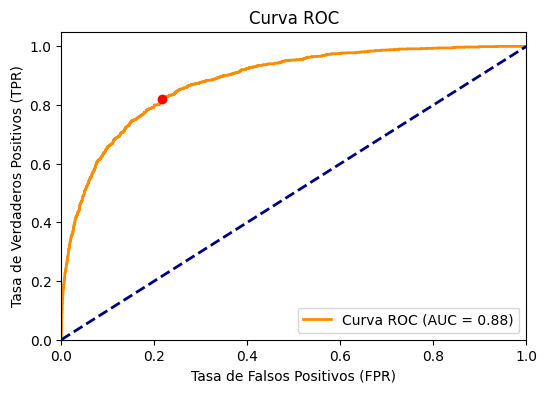

In [43]:
# Obtenemos las probabilidades de predicción del modelo
y_probs1 = model1.predict_proba(X_test_scaled)[:, 1]

# Calculamos la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs1)
roc_auc = auc(fpr, tpr)


# Calculamos la distancia euclidiana entre cada punto de la curva ROC y el punto ideal (0, 1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Enconteamos el índice del umbral con la menor distancia
min_distance_index = np.argmin(distances)

# Umbral óptimo
optimal_threshold = thresholds[min_distance_index]
print(f"Umbral óptimo (Distancia mínima al punto (0,1)): {optimal_threshold}")

# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.scatter(fpr[min_distance_index], tpr[min_distance_index], color='red', label=f'Umbral óptimo = {optimal_threshold:.2f}', zorder=5)
plt.show()

Observamos que la curva ROC queda por encima de la diagonal, con un área bajo la curva de 0.88, que es cercana a 1. Esto implicaría un buen fitting.

## Implementación de un modelo base

### Modelo base: Clasificación por moda, según el mes

In [44]:
#Definimos un modelo que clasifique por la moda de cada mes:
class ModaPorMesClasificador(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        # Guardamos los datos como un dataframe para manipular la columna de 'mes'
        data = pd.DataFrame(X).copy()
        data['RainTomorrow'] = y
        # Calculamos la moda por mes y las probabilidades:
        self.moda_por_mes_ = data.groupby('Mes')['RainTomorrow'].apply(lambda x: x.mode()[0])
        self.proba_por_mes_ = data.groupby('Mes')['RainTomorrow'].mean()  # Probabilidad de lluvia por mes
        return self

    def predict(self, X):
        # Para predecir, asignamos la moda correspondiente al mes de cada fila
        data = pd.DataFrame(X).copy()
        return data['Mes'].map(self.moda_por_mes_).values

    def predict_proba(self, X):
        # Asignamos la probabilidad correspondiente al mes de cada fila
        data = pd.DataFrame(X).copy()
        return data['Mes'].map(self.proba_por_mes_).values.reshape(-1, 1)

In [45]:
# Convertimos a dF
X_resampled_df = pd.DataFrame(X_resampled1, columns= nombres_columnas)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=nombres_columnas)
# Entrenamos el modelo
modelo_moda_por_mes = ModaPorMesClasificador()
modelo_moda_por_mes.fit(X_resampled_df, y_resampled1)

# Predicción con modelo base:
y_pred_base = modelo_moda_por_mes.predict(X_test_scaled_df)


In [46]:
y_ajuste_train_base = modelo_moda_por_mes.predict(X_resampled_df)

print("Métricas en el entrenamiento")
print(classification_report(y_resampled1, y_ajuste_train_base))
print(confusion_matrix(y_resampled1, y_ajuste_train_base))

print('Métricas en el conjunto de prueba')
print(classification_report(y_test, y_pred_base))
print(confusion_matrix(y_test, y_pred_base))

Métricas en el entrenamiento
              precision    recall  f1-score   support

         0.0       0.53      0.51      0.52     15591
         1.0       0.53      0.55      0.54     15591

    accuracy                           0.53     31182
   macro avg       0.53      0.53      0.53     31182
weighted avg       0.53      0.53      0.53     31182

[[7954 7637]
 [6954 8637]]
Métricas en el conjunto de prueba
              precision    recall  f1-score   support

         0.0       0.80      0.51      0.63      4435
         1.0       0.26      0.57      0.36      1328

    accuracy                           0.53      5763
   macro avg       0.53      0.54      0.49      5763
weighted avg       0.68      0.53      0.56      5763

[[2283 2152]
 [ 571  757]]


En este modelo base, la cantidad de FP para el modelo de entrenamiento es 7637, mientras que para el conjunto de prueba es 2152. Por otro lado, la cantidad de FN para entrenamiento es 6954 y 571 para prueba.

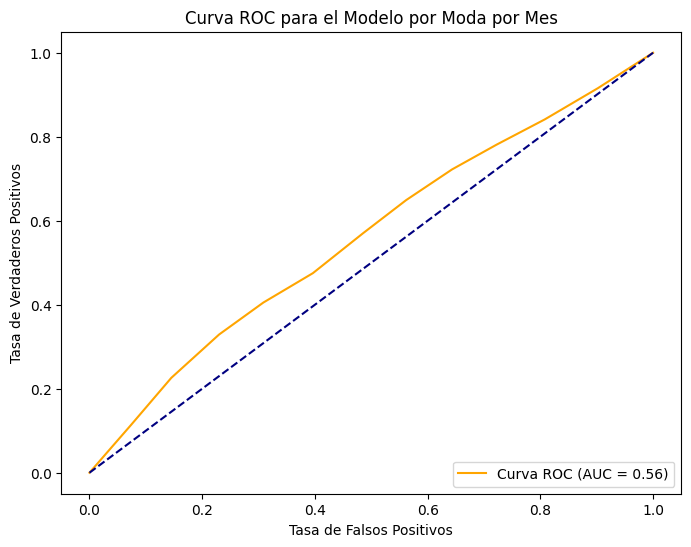

In [47]:
# Calculamos las probabilidades de la clase positiva
y_proba_base = modelo_moda_por_mes.predict_proba(X_test_scaled_df)

# Calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_base)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo por Moda por Mes')
plt.legend(loc="lower right")
plt.show()

La curva ROC se encuentra por encima de la recta identidad pero no tanto como la curva ROC correspondiente a regresión logística.

In [48]:
# Calculamos la distancia euclidiana entre cada punto de la curva ROC y el punto ideal (0, 1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
min_distance_index = np.argmin(distances)
optimal_threshold = thresholds[min_distance_index]
print(f"Umbral óptimo (Distancia mínima al punto (0,1)): {optimal_threshold}")

Umbral óptimo (Distancia mínima al punto (0,1)): 0.5005181347150259


Comparando los dos modelos de clasificación, el de regresión logística y el modelo base de clasificación por moda según el mes, vemos que logramos mejor fitting con el primero, dado que las métricas en general son mejores en el primer caso y además el área bajo la curva ROC es mayor, 0.88 contra 0.56 en el segundo caso.

## Validación cruzada k-folds y gridsearch

In [49]:
# Define el modelo
model = LogisticRegression(max_iter=1000)

# Define el espacio de hiperparámetros para la búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

#Configura GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

# Modelo con mejores hiperparámetros
best_model = grid_search.best_estimator_

# Evaluación en el conjunto de validación
val_predictions = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Precisión en conjunto de validación: {val_accuracy}")

# Evaluación en el conjunto de prueba
test_predictions = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Precisión en conjunto de prueba: {test_accuracy}")

Precisión en conjunto de validación: 0.8445523941707148
Precisión en conjunto de prueba: 0.8485163977095262


## Validación cruzada k-folds y RandomSearch

In [50]:
# Define el espacio de hiperparámetros para la búsqueda
param_distributions = {
    'C': uniform(0.1, 100),  # Prueba valores de 'C' en un rango continuo entre 0.1 y 100
    'solver': ['lbfgs', 'liblinear']
}

# Configura RandomizedSearchCV con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    scoring={'precision': 'precision', 'recall': 'recall'},  # Métricas múltiples
    refit='precision',  # Define la métrica a optimizar
    random_state=42  # Asegura reproducibilidad en la selección de combinaciones aleatorias
)

# Realiza la búsqueda de los mejores hiperparámetros
random_search.fit(X_train_scaled, y_train)

# Obtiene el mejor modelo
best_model = random_search.best_estimator_

# Evaluación en el conjunto de validación
val_predictions = best_model.predict(X_val_scaled)
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
print(f"Precisión en conjunto de validación: {val_precision}")
print(f"Recall en conjunto de validación: {val_recall}")

# Evaluación en el conjunto de prueba
test_predictions = best_model.predict(X_test_scaled)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
print(f"Precisión en conjunto de prueba: {test_precision}")
print(f"Recall en conjunto de prueba: {test_recall}")

Precisión en conjunto de validación: 0.718816067653277
Recall en conjunto de validación: 0.517503805175038
Precisión en conjunto de prueba: 0.7355371900826446
Recall en conjunto de prueba: 0.536144578313253


## Explicabilidad SHAP

In [51]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model1, X_train_scaled, feature_names=nombres_columnas)

# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)

In [52]:
shap_values.shape

(5763, 36)

In [53]:
explainer.expected_value #valor base

-0.6308667661331622

### Explicabilidad Local

In [54]:
index=0 #tomamos el primer registro
model1.predict_proba(X_test_scaled)[index]

model1.predict(X_test_scaled)[index]

shap_values[index]

array([ 2.41069522e-01, -3.79064898e-02, -3.48410958e-02,  2.85312005e-02,
       -3.99813083e-02,  7.49913181e-01,  2.40610338e-01,  1.97066184e-01,
       -2.22392762e-03, -6.67428810e-01, -1.83730378e+00,  2.97107067e+00,
       -2.65909351e-02,  2.13571708e-01, -5.52047842e-03,  3.95089214e-02,
       -9.07848779e-02, -1.49087270e-01, -1.04611161e-01,  5.60694944e-02,
        2.00552794e-02, -5.84897583e-02, -2.84784684e-02,  1.46616651e-01,
       -6.88719363e-02, -1.28714718e-01,  2.83138112e-02, -4.93166196e-02,
       -2.66840599e-02,  2.33081112e-02, -1.42610098e-02,  5.39171448e-02,
       -7.77656544e-02,  1.06507990e-01, -8.72515557e-02, -2.14273211e-02])

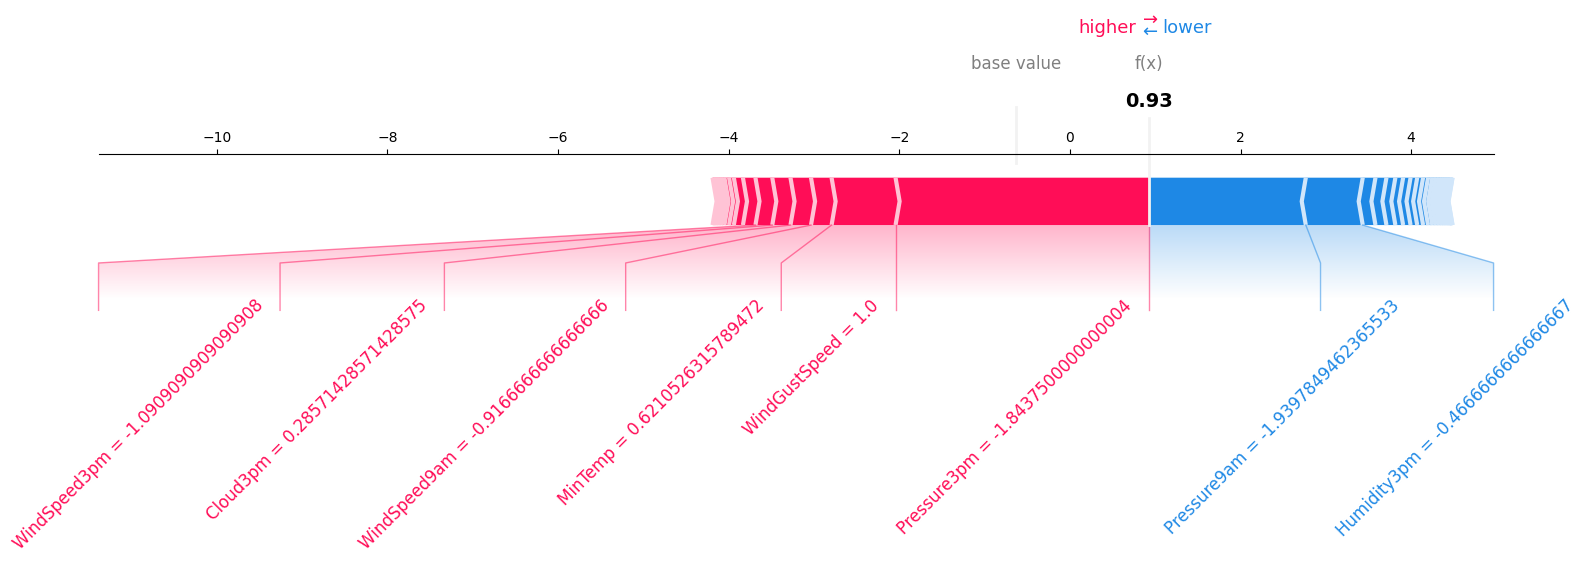

In [55]:
shap.force_plot(explainer.expected_value, shap_values[index], X_test_scaled[index], feature_names=nombres_columnas, matplotlib=True, figsize=(18, 4), text_rotation=45)

In [56]:
explanation_local = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=nombres_columnas)

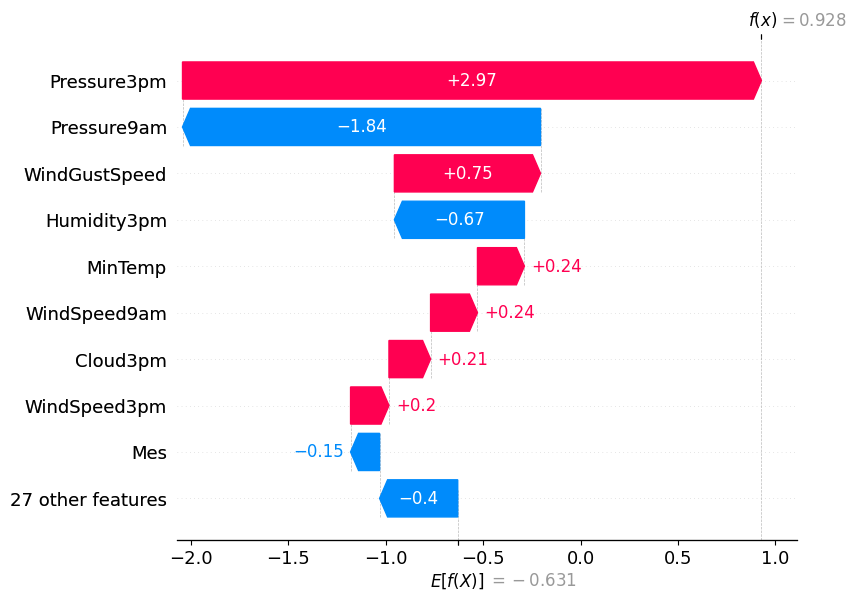

In [57]:
shap.plots.waterfall(explanation_local)

De los gráficos realizados, para este registro en particular, podemos observar que el valor predicho (0.928) se explica en mayor medida por las variables "Pressure3pm" que desvía hacia la clase 1 con un valor de SHAP de 2.97, en segundo lugar "Pressure9am" que desvía hacia la izquierda, es decir, hacia la clase 0 con un valor de -1.84, en tercer lugar "WindGustSpeed" con un valor de 0.75 y en cuarto lugar "Humidity3pm" con un valor de -0.67.

### Explicabilidad global

In [58]:
explanation_global = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=nombres_columnas, data=X_test_scaled)

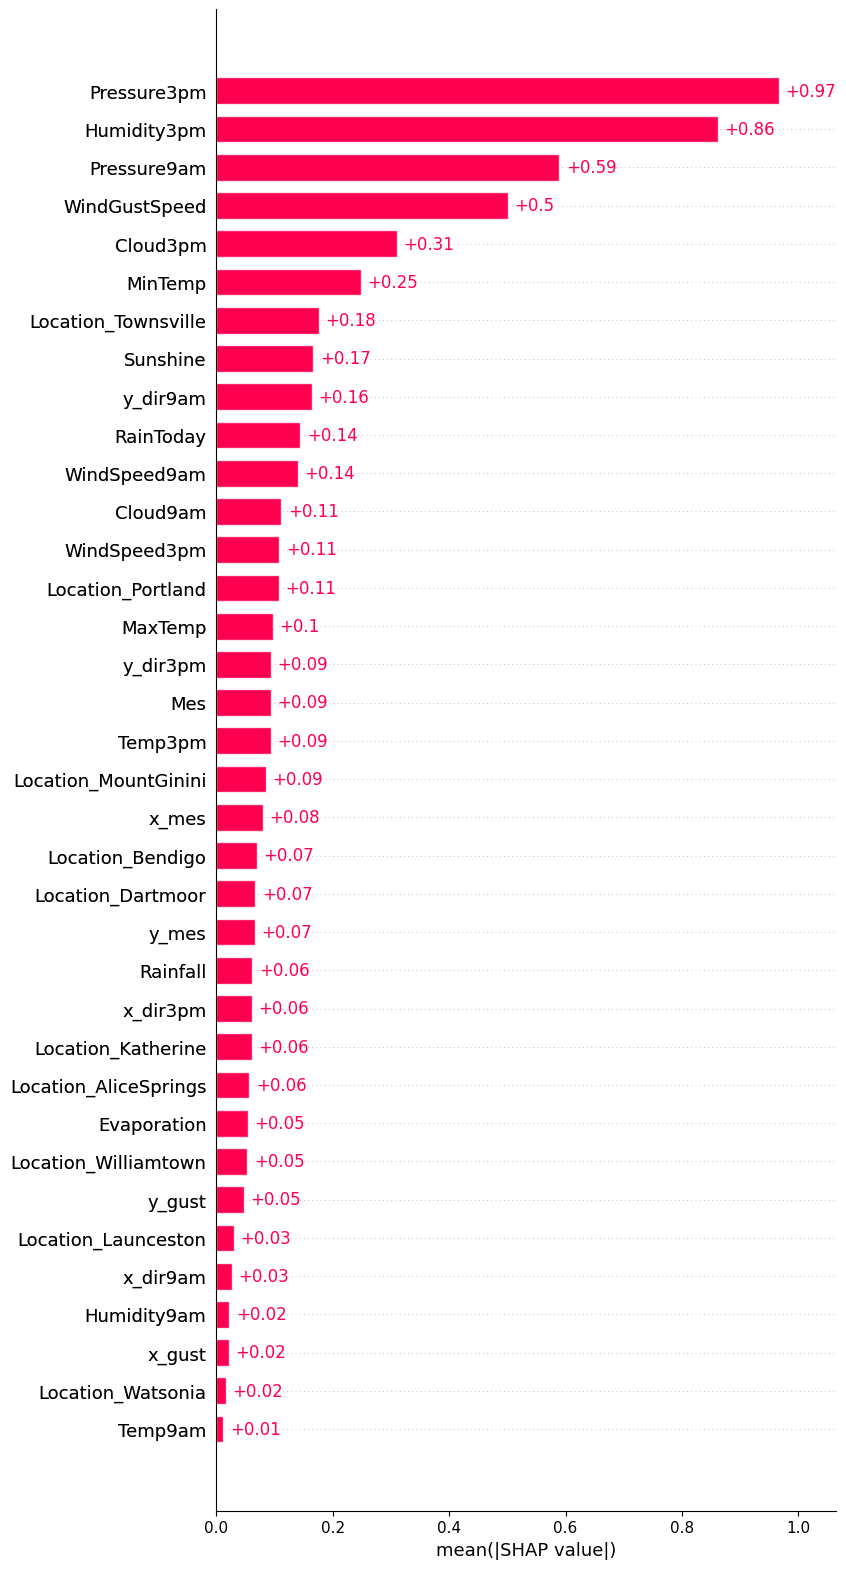

In [59]:
shap.plots.bar(explanation_global, max_display=36)

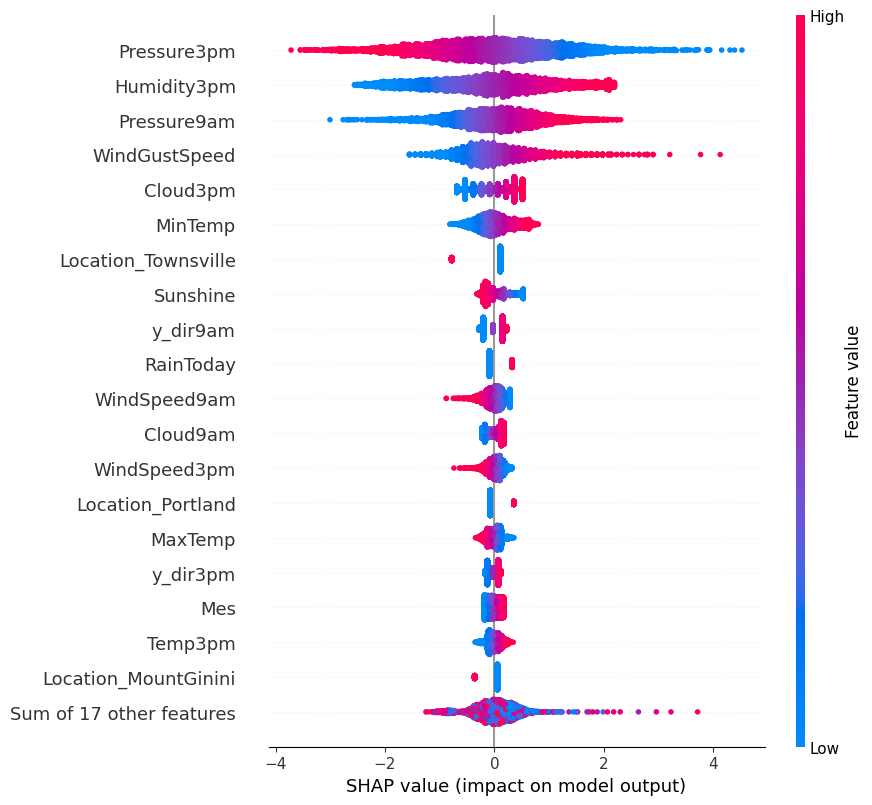

In [60]:
shap.plots.beeswarm(explanation_global, max_display=20)

En estos gráficos globales, podemos ver que las variables más importantes son  "Pressure3pm", con un valor shap de +0.97, seguida de "Humidity3pm", con +0.86, luego "Pressure9am" con +0.59 y "WindGustSpeed" con +0.5. Y las menos importantes son "Temp9am" con un valor SHAP de +0.01, seguida por "Location_Watsonia", "x_gust" y "Humidity9am" con un valor de +0.02 y luego con 0.03 tenemos a "x_dir9am" y "Location_Launceston".
Por otro lado, observando el gráfico de Enjambre, notamos que valores altos de Pressure3pm desvían la predicción hacia la clase 0, mientras que valores altos de Humidity3pm, Pressure9am y WindGustSpeed desvían la predicción hacia la clase 1.



##Modelo de autoML


In [61]:
from pycaret.classification import *


X = df_clima.drop('RainTomorrow', axis=1)
y = df_clima['RainTomorrow']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.concat([X_train_, y_train_], axis=1)

clf = setup(data=train_data, target='RainTomorrow', session_id=42, test_data = pd.concat([X_test_, y_test_], axis=1))

best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(28814, 23)"
4,Transformed data shape,"(28814, 53)"
5,Transformed train set shape,"(23051, 53)"
6,Transformed test set shape,"(5763, 53)"
7,Numeric features,17
8,Categorical features,5
9,Rows with missing values,63.8%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8437,0.8724,0.5062,0.7222,0.5951,0.5019,0.5142,6.4810
et,Extra Trees Classifier,0.8433,0.8799,0.4850,0.7350,0.5841,0.4925,0.5088,5.6670
lightgbm,Light Gradient Boosting Machine,0.8393,0.8100,0.5444,0.6838,0.6059,0.5067,0.5120,4.5290
lr,Logistic Regression,0.8390,0.8670,0.4995,0.7056,0.5849,0.4886,0.4999,3.7590
xgboost,Extreme Gradient Boosting,0.8377,0.8145,0.5477,0.6759,0.6049,0.5042,0.5087,1.4210
gbc,Gradient Boosting Classifier,0.8371,0.8029,0.5200,0.6872,0.5917,0.4925,0.5001,7.6720
ridge,Ridge Classifier,0.8311,0.8536,0.4550,0.6963,0.5502,0.4518,0.4674,0.6230
lda,Linear Discriminant Analysis,0.8288,0.8520,0.5026,0.6625,0.5715,0.4670,0.4741,0.7900
knn,K Neighbors Classifier,0.8277,0.8184,0.4902,0.6636,0.5637,0.4594,0.4677,1.2490
ada,Ada Boost Classifier,0.8256,0.8049,0.5167,0.6452,0.5738,0.4659,0.4705,1.8100


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

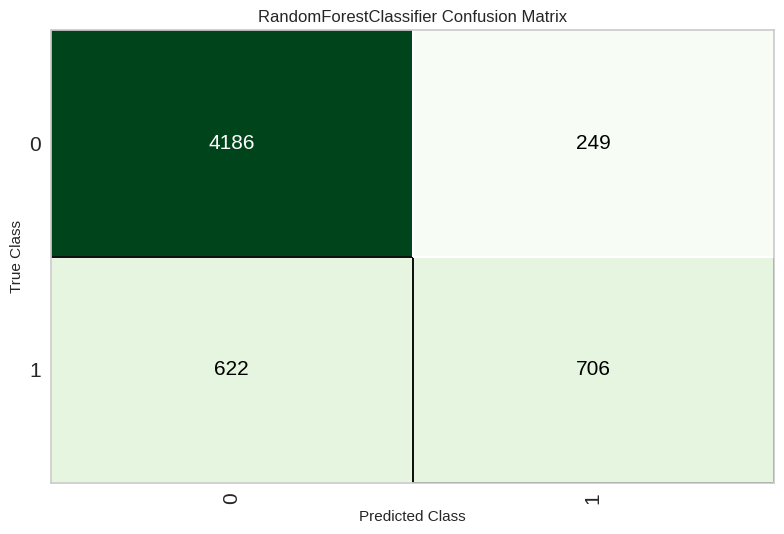

In [62]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

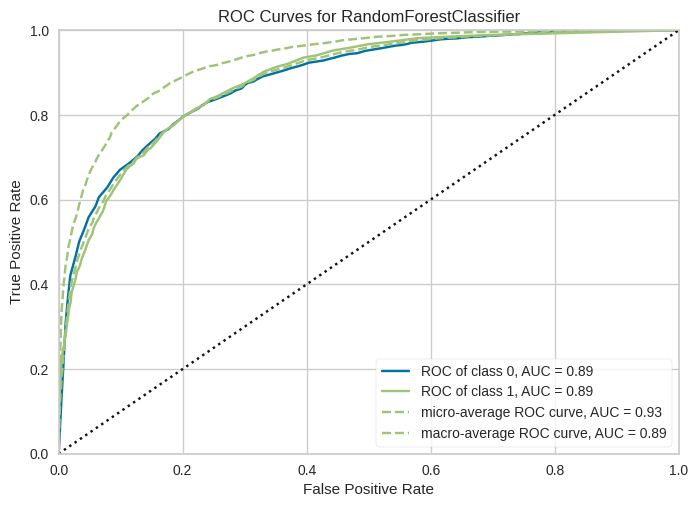

In [63]:
# plot AUC
plot_model(best_model, plot = 'auc')

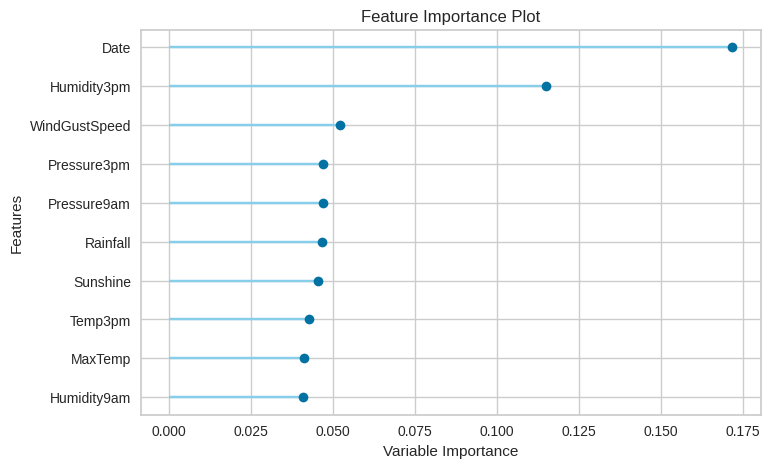

In [64]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [65]:
holdout_pred = predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8489,0.8851,0.5316,0.7393,0.6185,0.5274,0.5385


Se observa que aplicando autoML, el mejor modelo corresponde a Random Forest Classifier, con las métricas dadas en la celda anterior. Dicho modelo presenta los mejores valores de las métricas accuracy y MCC.
En el último gráfico se muestra la importancia de las variables en el modelo, siendo la de mayor importancia "Date", lo que resulta llamativo.

## Solución con red neuronal

In [66]:
#Importamos librerías de tensor flow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [67]:
#Ajuste para balancear el impacto de las clases desbalanceadas en la función de pérdida
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y),
                                     y=y)
class_weights = dict(enumerate(class_weights))

In [76]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo con TensorFlow.
        En esta clase, se construye el modelo,
        se define como se fitea el modelo,
        y como se hacen las predicciones.
    """
    def __init__(self, learning_rate=0.01, epochs=500, hidden_units=2, hidden_layers=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hidden_units = hidden_units  # Número de neuronas en la capa oculta
        self.hidden_layers = hidden_layers # Número de capas ocultas
        self.model = None

    def build_model(self):
        """
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que coloca
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected.
            Se agregan capas ocultas,
            y una capa de salida de regresión (una única neurona).

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression()
            en el caso de la regresión lineal.
        """
        model = Sequential()

        # Agregar la primera capa oculta (necesita especificar input_shape)
        model.add(Dense(self.hidden_units, activation='relu', input_shape=(X_train_scaled.shape[1],)))

        # Agregar capas ocultas adicionales (sin input_shape, ya se ajusta automáticamente)
        for _ in range(self.hidden_layers - 1):  # self.hidden_layers indica el número total de capas ocultas
            model.add(Dense(self.hidden_units, activation='relu'))

        # Agregar la capa de salida
        model.add(Dense(1))  # Una neurona para regresión

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

        self.model = model

        # imprimir la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y):
      """ Esta es la función donde se entrena el modelo, hay un learning rate e iteraciones,
      la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución. """
      X = np.array(X)
      y = np.array(y)

      if self.model is None:
        self.build_model()

      early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

      history = self.model.fit(X, y, epochs=self.epochs, batch_size=32, verbose=0, class_weight=class_weights, callbacks=[early_stopping])

      return history.history

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [77]:
nn_tensorflow = NeuralNetworkTensorFlow(learning_rate=0.001, epochs=50, hidden_layers=2)

history = nn_tensorflow.fit(X_train_scaled, y_train)

loss_history = history['loss']
recall_history = history['Recall']

print("Pérdida por época:", loss_history)
print("Recall por época:", recall_history)


n° de parámetros: 83
Pérdida por época: [1.091247320175171, 0.7687346339225769, 0.6082254648208618, 0.5553432703018188, 0.5205707550048828, 0.49235811829566956, 0.4863523840904236, 0.4779968559741974, 0.4868936538696289, 0.47703972458839417, 0.4731328785419464, 0.4680462181568146, 0.4665524959564209, 0.469038188457489, 0.4635776877403259, 0.46125560998916626, 0.4611244797706604, 0.4602298438549042, 0.4619019031524658, 0.4611782729625702, 0.46125566959381104, 0.4612034261226654, 0.4610705077648163, 0.4726980924606323, 0.4596704840660095, 0.45945143699645996, 0.4579228460788727, 0.4564175009727478, 0.458492249250412, 0.4599722623825073, 0.4566023647785187, 0.4551020562648773, 0.4571377635002136, 0.45992565155029297, 0.45381709933280945, 0.4536459743976593, 0.45759764313697815, 0.45728030800819397, 0.4547697901725769, 0.45212316513061523, 0.45447367429733276, 0.46351611614227295, 0.4557666480541229, 0.4535723924636841, 0.4530659317970276, 0.4528392255306244, 0.45771583914756775, 0.4524015

In [78]:
#Nos quedamos con el accuracy de la regresión logística para luego comparar con la solución de red neuronal
accuracy_train1 = accuracy_score(y_resampled1, y_ajuste_train1)

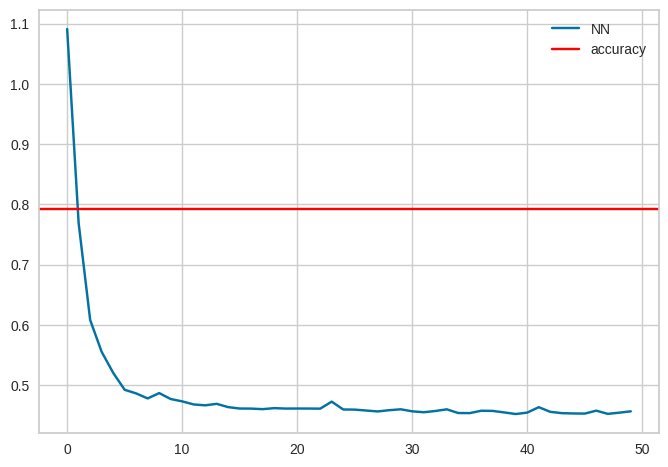

In [79]:
plt.plot(loss_history, label='NN')
plt.axhline(accuracy_train1, color='red', label='accuracy',linestyle = '-')
plt.legend()
plt.show()

In [80]:
loss_history[-1]

0.45660555362701416

In [81]:
recall_history[-1]

0.8171690702438354

In [82]:
predictions = nn_tensorflow.predict(X_train_scaled)
print("Predicciones:", predictions)

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predicciones: [[0.26238316]
 [0.02230965]
 [0.02230965]
 ...
 [0.4259161 ]
 [0.7467135 ]
 [0.02230965]]


In [83]:
loss, accuracy, Recall = nn_tensorflow.model.evaluate(X_test_scaled, y_test)
print(f'Pérdida test: {loss}')
print(f'Exactitud test: {accuracy}')
print(f'Recall test: {Recall}')

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8265 - accuracy: 0.7983 - loss: 0.4256
Pérdida test: 0.44695261120796204
Exactitud test: 0.7893458008766174
Recall test: 0.8275602459907532


Vemos que la perdida tanto en test como en entrenamiento es parecida, algo similar sucede con Recall donde en ambos conjuntos arroja un buen resultado, por lo que podemos decir que no hay overfitting.

## Optuna

In [84]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [85]:
import optuna

In [86]:
# Se establece la semilla en Python, para que optuna devuelva siempre los mismos resultados
import random
import tensorflow as tf

random.seed(25)
np.random.seed(25)
tf.random.set_seed(25)

In [87]:
def objective1(trial):
    # Sugerir hiperparámetros
    learning_rate = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])
    epochs = trial.suggest_int('epochs', 5, 60, step=5)
    hidden_units = trial.suggest_int('hidden_units', 1, 10)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 5)  # Número de capas ocultas

    # Crear y entrenar el modelo con los parámetros sugeridos
    model_op = NeuralNetworkTensorFlow(learning_rate=learning_rate, epochs=epochs, hidden_units=hidden_units, hidden_layers=hidden_layers)

    history_op = model_op.fit(X_train_scaled, y_train)

    # Optuna espera un escalar, seleccionamos la última pérdida
    final_loss_op = history_op['loss'][-1]  # Último valor de pérdida

    return final_loss_op

In [88]:
# Crear un estudio de Optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))  # Queremos minimizar la pérdida
study.optimize(objective1, n_trials=15)  # Ejecutar la optimización por 15 pruebas

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores parámetros: {study.best_params}")

# Crear el modelo con los mejores hiperparámetros y entrenarlo
best_params = study.best_params
best_model = NeuralNetworkTensorFlow(
    learning_rate=best_params['learning_rate'],
    epochs=best_params['epochs'],
    hidden_units=best_params['hidden_units'],
    hidden_layers=best_params['hidden_layers']
)

history_optuna = best_model.fit(X_train_scaled, y_train)

# Realizar predicciones con el mejor modelo
predictions = best_model.predict(X_test_scaled)

[I 2024-11-30 18:11:14,929] A new study created in memory with name: no-name-41fa229f-807d-4cc3-986a-048d15562e0d


n° de parámetros: 77


[I 2024-11-30 18:12:06,265] Trial 0 finished with value: 7.979330062866211 and parameters: {'learning_rate': 0.01, 'epochs': 40, 'hidden_units': 2, 'hidden_layers': 1}. Best is trial 0 with value: 7.979330062866211.


n° de parámetros: 47


[I 2024-11-30 18:12:26,007] Trial 1 finished with value: 8.031124114990234 and parameters: {'learning_rate': 0.01, 'epochs': 45, 'hidden_units': 1, 'hidden_layers': 5}. Best is trial 0 with value: 7.979330062866211.


n° de parámetros: 193


[I 2024-11-30 18:12:40,822] Trial 2 finished with value: 7.979330062866211 and parameters: {'learning_rate': 0.1, 'epochs': 15, 'hidden_units': 4, 'hidden_layers': 3}. Best is trial 0 with value: 7.979330062866211.


n° de parámetros: 127


[I 2024-11-30 18:12:54,090] Trial 3 finished with value: 0.5182570815086365 and parameters: {'learning_rate': 0.001, 'epochs': 10, 'hidden_units': 3, 'hidden_layers': 2}. Best is trial 3 with value: 0.5182570815086365.


n° de parámetros: 229


[I 2024-11-30 18:13:17,846] Trial 4 finished with value: 0.5719999074935913 and parameters: {'learning_rate': 0.01, 'epochs': 35, 'hidden_units': 6, 'hidden_layers': 1}. Best is trial 3 with value: 0.5182570815086365.


n° de parámetros: 821


[I 2024-11-30 18:13:34,369] Trial 5 finished with value: 8.031124114990234 and parameters: {'learning_rate': 0.1, 'epochs': 60, 'hidden_units': 10, 'hidden_layers': 5}. Best is trial 3 with value: 0.5182570815086365.


n° de parámetros: 89


[I 2024-11-30 18:14:14,690] Trial 6 finished with value: 0.47499528527259827 and parameters: {'learning_rate': 0.001, 'epochs': 30, 'hidden_units': 2, 'hidden_layers': 3}. Best is trial 6 with value: 0.47499528527259827.


n° de parámetros: 193


[I 2024-11-30 18:14:43,955] Trial 7 finished with value: 8.031124114990234 and parameters: {'learning_rate': 0.01, 'epochs': 40, 'hidden_units': 4, 'hidden_layers': 3}. Best is trial 6 with value: 0.47499528527259827.


n° de parámetros: 821


[I 2024-11-30 18:15:52,546] Trial 8 finished with value: 0.41780784726142883 and parameters: {'learning_rate': 0.001, 'epochs': 50, 'hidden_units': 10, 'hidden_layers': 5}. Best is trial 8 with value: 0.41780784726142883.


n° de parámetros: 41


[I 2024-11-30 18:16:08,261] Trial 9 finished with value: 8.031124114990234 and parameters: {'learning_rate': 0.01, 'epochs': 15, 'hidden_units': 1, 'hidden_layers': 2}. Best is trial 8 with value: 0.41780784726142883.


n° de parámetros: 711


[I 2024-11-30 18:17:17,286] Trial 10 finished with value: 0.4691163897514343 and parameters: {'learning_rate': 0.001, 'epochs': 60, 'hidden_units': 10, 'hidden_layers': 4}. Best is trial 8 with value: 0.41780784726142883.


n° de parámetros: 711


[I 2024-11-30 18:18:37,842] Trial 11 finished with value: 0.40704038739204407 and parameters: {'learning_rate': 0.001, 'epochs': 60, 'hidden_units': 10, 'hidden_layers': 4}. Best is trial 11 with value: 0.40704038739204407.


n° de parámetros: 521


[I 2024-11-30 18:19:23,768] Trial 12 finished with value: 0.4610143303871155 and parameters: {'learning_rate': 0.001, 'epochs': 50, 'hidden_units': 8, 'hidden_layers': 4}. Best is trial 11 with value: 0.40704038739204407.


n° de parámetros: 521


[I 2024-11-30 18:19:56,952] Trial 13 finished with value: 0.4593505561351776 and parameters: {'learning_rate': 0.001, 'epochs': 55, 'hidden_units': 8, 'hidden_layers': 4}. Best is trial 11 with value: 0.40704038739204407.


n° de parámetros: 593


[I 2024-11-30 18:20:32,210] Trial 14 finished with value: 0.44194796681404114 and parameters: {'learning_rate': 0.001, 'epochs': 50, 'hidden_units': 8, 'hidden_layers': 5}. Best is trial 11 with value: 0.40704038739204407.


Mejores parámetros: {'learning_rate': 0.001, 'epochs': 60, 'hidden_units': 10, 'hidden_layers': 4}
n° de parámetros: 711
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


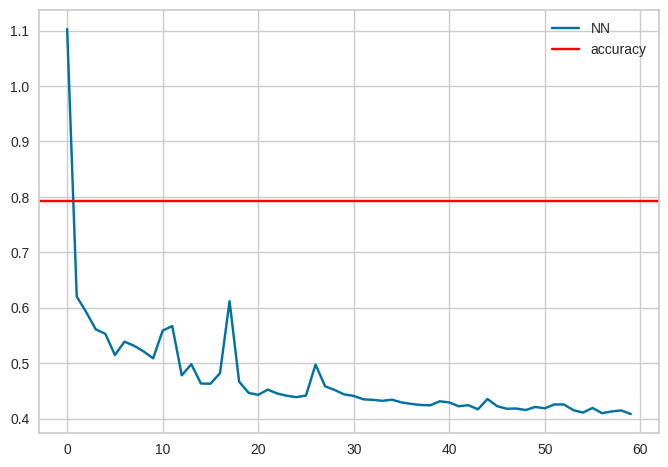

In [89]:
# Graficamos la función de pérdida para visualizar su evolución
plt.plot(history_optuna['loss'], label='NN')
plt.axhline(accuracy_train1, color='red', label='accuracy',linestyle = '-')
plt.legend()
plt.show()

In [90]:
loss_history_optuna = history_optuna['loss']
Recall_history_optuna = history_optuna['Recall']

print(f'Pérdida entrenamiento: {loss_history_optuna[-1]}')
print(f'Recall entrenamiento: {Recall_history_optuna[-1]}')


Pérdida entrenamiento: 0.40826743841171265
Recall entrenamiento: 0.8501529097557068


In [91]:
loss, accuracy, Recall = best_model.model.evaluate(X_test_scaled, y_test)
print(f'Pérdida test: {loss}')
print(f'Exactitud test: {accuracy}')
print(f'Recall test: {Recall}')

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Recall: 0.8519 - accuracy: 0.8018 - loss: 0.4319
Pérdida test: 0.4578615427017212
Exactitud test: 0.7893458008766174
Recall test: 0.8463855385780334


## Shap

In [92]:
X_train_scaled_ = np.array(X_train_scaled)

# Crear el objeto explainer para redes neuronales
explainer_nn = shap.DeepExplainer(nn_tensorflow.model, X_train_scaled_)

# Calcular los valores SHAP
shap_values = explainer_nn.shap_values(X_train_scaled_)

In [93]:
shap_values

array([[[ 0.10886975],
        [-0.0114261 ],
        [-0.05048907],
        ...,
        [ 0.00768686],
        [-0.00674254],
        [-0.02497214]],

       [[ 0.04084664],
        [-0.00303325],
        [-0.05028541],
        ...,
        [-0.02260721],
        [-0.00432467],
        [-0.01768171]],

       [[-0.00940247],
        [-0.00093475],
        [-0.04076439],
        ...,
        [-0.01570545],
        [-0.00307817],
        [-0.0121724 ]],

       ...,

       [[-0.05596635],
        [ 0.00368468],
        [-0.01075796],
        ...,
        [-0.00039965],
        [-0.01276514],
        [ 0.14084033]],

       [[ 0.00668828],
        [ 0.00250015],
        [ 0.11201502],
        ...,
        [-0.00491341],
        [ 0.12857266],
        [-0.01243132]],

       [[-0.00970142],
        [-0.00125344],
        [-0.03912008],
        ...,
        [ 0.00297352],
        [-0.00197476],
        [-0.01102944]]])

Explicabilidad local

In [94]:
index=0 #tomamos el primer registro
nn_tensorflow.model.predict(X_test_scaled)[index]

nn_tensorflow.model.predict(X_test_scaled)[index]

shap_values[index]

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[ 0.10886975],
       [-0.0114261 ],
       [-0.05048907],
       [-0.00212082],
       [ 0.0229357 ],
       [ 0.04807   ],
       [-0.01743727],
       [-0.03258486],
       [-0.00405747],
       [-0.0144598 ],
       [-0.02967133],
       [ 0.21589005],
       [-0.01494673],
       [-0.0474382 ],
       [-0.01863305],
       [-0.02623775],
       [ 0.00104427],
       [ 0.01828755],
       [ 0.01704104],
       [-0.01894547],
       [-0.02491105],
       [-0.02097112],
       [-0.01761001],
       [ 0.01730403],
       [-0.0096896 ],
       [-0.02537152],
       [-0.00757241],
       [-0.0132422 ],
       [-0.0196107 ],
       [-0.06521052],
       [-0.0198585 ],
       [-0.01011162],
       [-0.01859631],
       [ 0.00768686],
       [-0.00674254],
       [-0.02497214]])

In [95]:
shap_values_sample = shap_values[index, :, 0]
X_sample = X_test_scaled[index].reshape(-1)
X_sample.shape

(36,)

In [96]:
print(type(explainer_nn.expected_value))
print(explainer_nn.expected_value.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1,)


0.378172


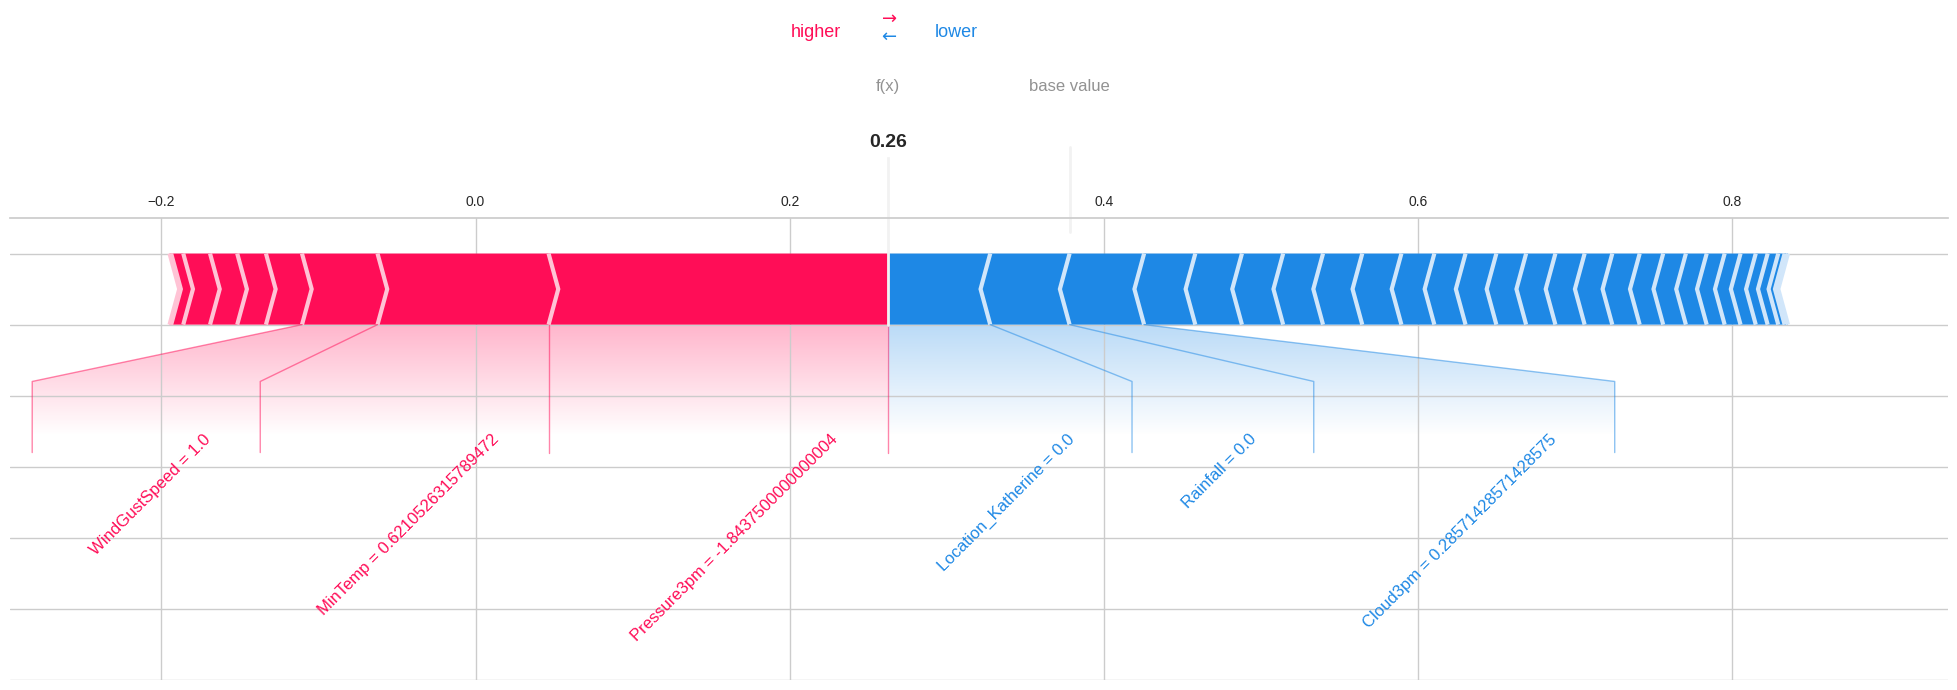

In [97]:
# Como es un tensor, convertimos a un array de NumPy, para que expected_value sea un escalar
expected_value = explainer_nn.expected_value.numpy() if isinstance(explainer_nn.expected_value, tf.Tensor) else explainer_nn.expected_value


# Si expected_value tiene más de una dimensión (como un array de tamaño (1,)), selecciona el primer valor
expected_value = expected_value.flatten()[0] if expected_value.ndim > 0 else expected_value

print(expected_value)  # Esto debería ser un número escalar

shap.force_plot(
    expected_value,
    shap_values_sample,
    X_sample,
    feature_names=nombres_columnas,
    matplotlib=True,
    figsize=(25, 6),
    text_rotation=45
)

In [98]:
# Si explainer_nn.expected_value es un escalar o un solo valor, conviértelo en un array
expected_value = np.array([expected_value] * len(nombres_columnas))

# Luego crea el objeto Explanation
explanation_local_nn = shap.Explanation(
    values=shap_values[index],
    base_values=expected_value,  # Ahora expected_value tiene la forma correcta
    feature_names=nombres_columnas
)

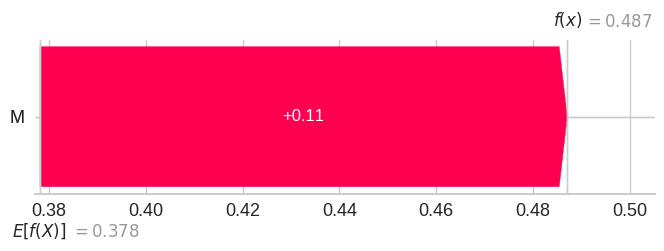

In [99]:
shap.plots.waterfall(explanation_local_nn[0])

Explicabilidad global

In [100]:
explanation_global_nn = shap.Explanation(values=shap_values, base_values=expected_value, feature_names=nombres_columnas, data=X_test_scaled)

In [101]:
# Asegúrate de que explanation_global_nn sea un objeto shap.Explanation
print(type(explanation_global_nn))  # Esto debería imprimir <class 'shap.Explanation'>
print(len(explanation_global_nn.values))  # Verifica cuántos valores SHAP hay (número de características)

<class 'shap._explanation.Explanation'>
20169


In [102]:
max_display = len(explanation_global_nn.values)
shap.plots.bar(explanation_global_nn, max_display=max_display)

IndexError: list index out of range

##Comparación de modelos


A partir de los distintos modelos desarrollados durante todo el trabajo práctico, haremos una comparación de los mismos a través de la métrica seleccionada. Esta es el Recall de la clase positiva, dado que consideramos que queremos minimizar los resultados "Falsos negativos", que representan que se predice que no lloverá, y luego sí lo hace.

**Analizamos la métrica Recall de los distintos modelos:**

- Modelo Regresión Logística:

  Recall test: 0.80

- Modelo base Moda por Mes Clasificador:

  Recall test: 0.57

- Modelo validación cruzada k-folds y RandomSearch:

  Recall test: 0.536

- Modelo autoML Random Forest Classifier:

  Recall test: 0.5316

- Modelo red neuronal nn_tensorflow:

  Recall test: 0.82

- Modelo red neuronal optuna:

  Recall test: 0.84



Con estos resultados, consideramos que el mejor modelo obtenido es el que corresponde a Redes Neuronales con los hiperparámetros que brindó Optuna.

# Guardado de datos, modelo, escalador, para puesta en producción

In [103]:
import joblib

joblib.dump(moda_por_mes_windgustdir, 'moda_por_mes_windgustdir.pkl')
joblib.dump(moda_por_mes_winddir9am , 'moda_por_mes_winddir9am.pkl')
joblib.dump(moda_por_mes_winddir3pm, 'moda_por_mes_winddir3pm.pkl')
joblib.dump(moda_por_mes_raintoday, 'moda_por_mes_raintoday.pkl')

joblib.dump(asignar_coordenadas, 'asignar_coordenadas.pkl')
joblib.dump(asignar_coordenadas_gustdir, 'asignar_coordenadas_gustdir.pkl')
joblib.dump(asignar_coordenadas_dir9am, 'asignar_coordenadas_dir9am.pkl')
joblib.dump(asignar_coordenadas_dir3pm, 'asignar_coordenadas_dir3pm.pkl')

# Guardar el modelo entrenado
joblib.dump(best_model, 'best_model.pkl')

# Guardar el escalador para columnas numéricas
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']